In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_palette('pastel')
sns.set_theme(style='whitegrid')

import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Import Tukey's HSD function
from statsmodels.stats.multicomp import pairwise_tukeyhsd


## Notes

In this notebook we are going to look into One way and Two way ANOVA. Is based on a class from the Google Data Analytics Certificate, Regression Analysis.

The main idea while doing it was to study about ANOVA test. I hope is helpful and thanks Google for the course.

Related subjects:

**Regression**: Regression analysis will help provide a holistic picture of **if and by how much** a number of different variables impact an outcome variable

**ANOVA**: Pairwise comparisons, understand sometimes subtle difference among elements that fueled regression analysis. ANOVA is a magnification glass.

We took a subset of colorless and near colorless diamonds. We egoing to exclude G color grade diamonds as there were many more of them, and we will exlclude J color grade diamonds as there were significantly fewer of them. 

STEPS:
1. EDA
2. Descriptive statistics
3. ANOVA



In [2]:
## loading data and displaying some of its information

path = '/kaggle/input/diamonds-prices/Diamonds Prices2022.csv'

df = pd.read_csv(path)

df.sample(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
15594,15595,1.14,Premium,G,VS2,61.9,58.0,6256,6.72,6.68,4.15
16494,16495,1.02,Ideal,G,VS2,62.6,56.0,6591,6.40,6.44,4.02
14803,14804,1.10,Premium,G,VS1,62.2,59.0,5958,6.61,6.57,4.10
22713,22714,1.23,Very Good,E,VS1,61.5,58.0,10730,6.88,6.93,4.25
23312,23313,1.50,Very Good,D,SI1,63.5,57.0,11352,7.23,7.28,4.61


In [3]:
## Observing missing values, (no missing values)
#df.isnull().sum().sort_values()

In [4]:
## Data types and meta-d.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53943 non-null  int64  
 1   carat       53943 non-null  float64
 2   cut         53943 non-null  object 
 3   color       53943 non-null  object 
 4   clarity     53943 non-null  object 
 5   depth       53943 non-null  float64
 6   table       53943 non-null  float64
 7   price       53943 non-null  int64  
 8   x           53943 non-null  float64
 9   y           53943 non-null  float64
 10  z           53943 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [5]:
## Obtaining features by data type.
df.drop(['Unnamed: 0'], axis=1, inplace=True)
nums = df.select_dtypes(['int64', 'float64']).columns.to_list()
objs = df.select_dtypes(['object']).columns.to_list()

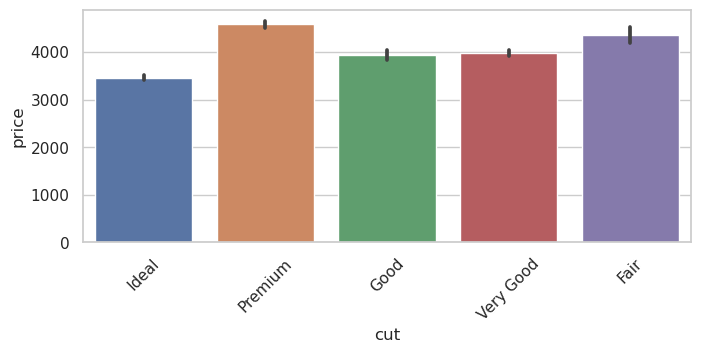

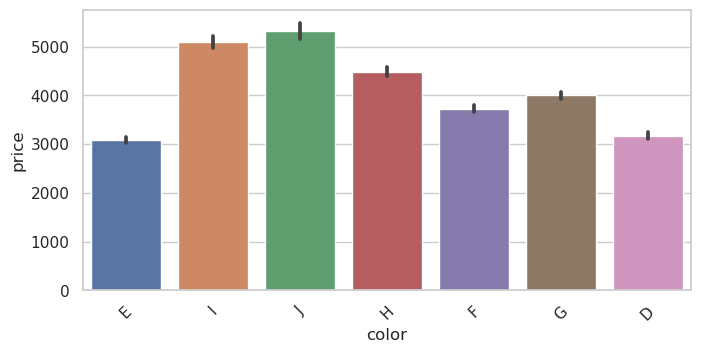

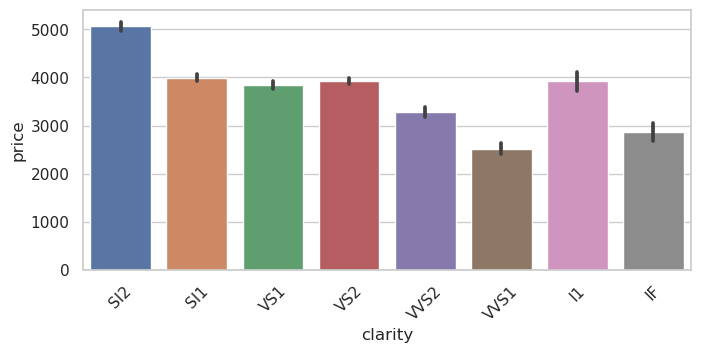

In [6]:
## Observing categorical variables.

for obj in objs[:]:
    plt.figure(figsize = (8.48,5)) #18, 8
    sns.barplot(x=obj, y='price', data=df);
    plt.xticks(rotation=45)
    plt.tight_layout(pad=5.0)
    plt.show()

In [7]:
## Here we have the counts per color.
## we can observe that we have more G and 
## little amount of J.
df['color'].value_counts()

G    11292
E     9799
F     9543
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

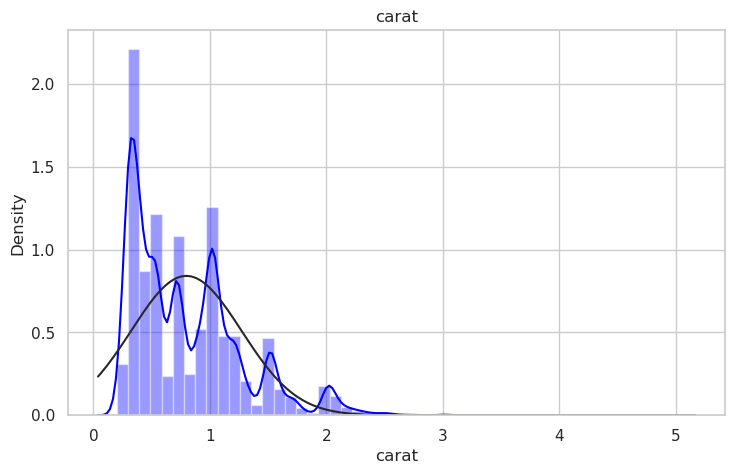

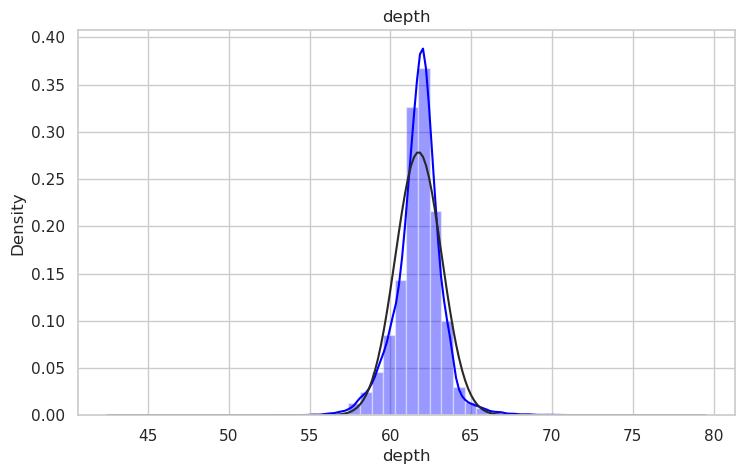

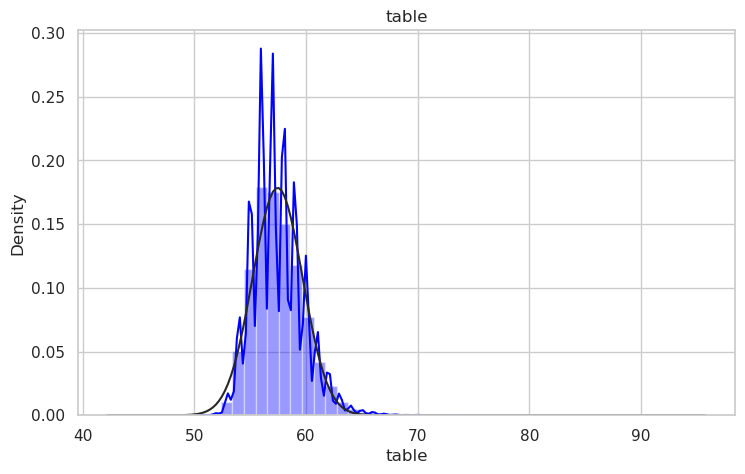

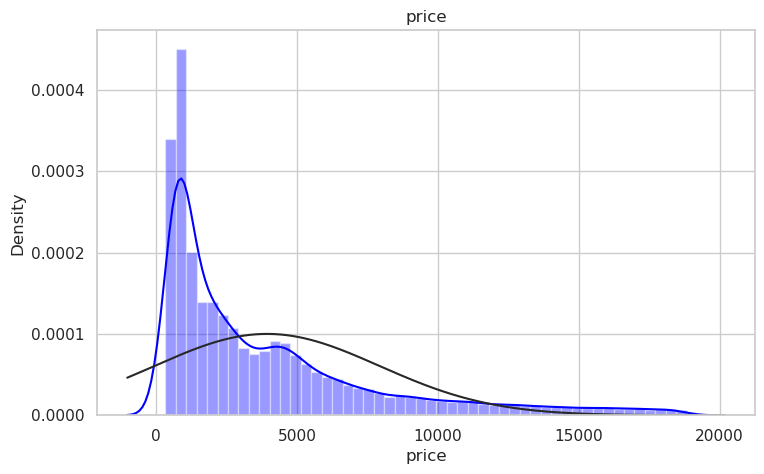

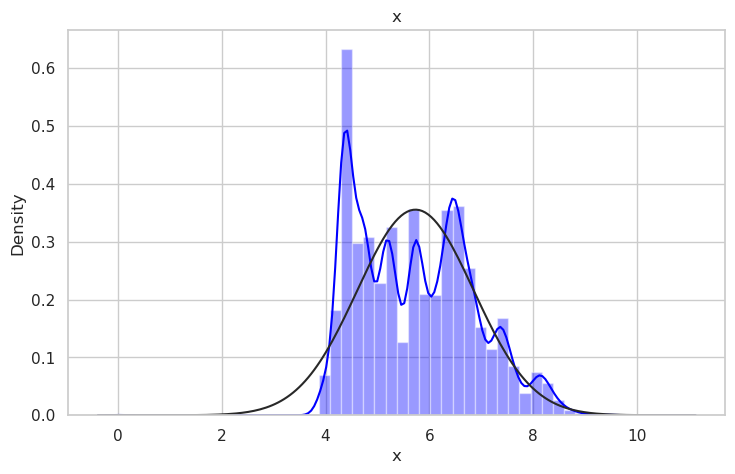

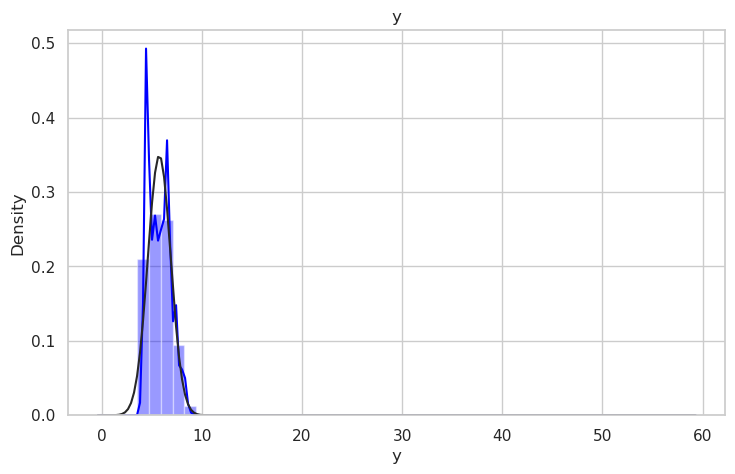

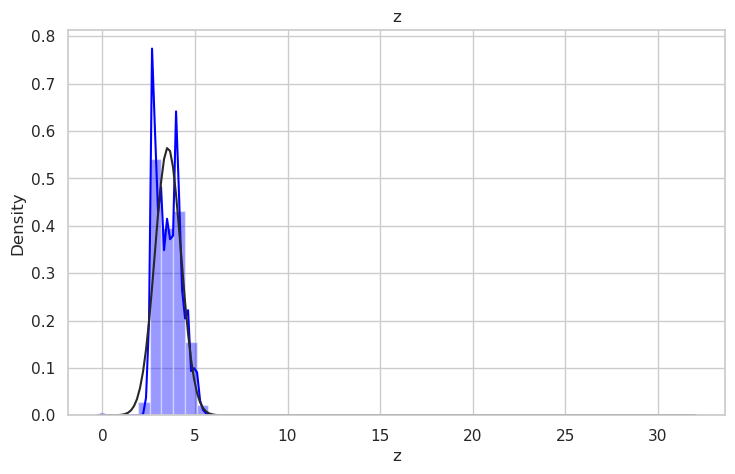

In [8]:
## Observing Distribution of the continious variables and responce.
## 
for col in nums:
    plt.figure(figsize = (8.48,5))
    sns.distplot(df[col], kde=True, fit=scipy.stats.norm , color='Blue')
    plt.title(col)

In [9]:
## Selecting the categorical feature color data for our experiment.
## Obtaining a subset for colorless diamonds
diamantes = df[df["color"].isin(["E","F","H","D","I"])]

# Select only color and price columns, and reset index
diamantes = pd.DataFrame(diamantes[["color","price"]]).reset_index(drop=True)

In [10]:
diamantes['color'].unique()

array(['E', 'I', 'H', 'F', 'D'], dtype=object)

In [11]:
# Check that the dropped categories have been removed
diamantes['color'].values

array(['E', 'E', 'E', ..., 'E', 'F', 'E'], dtype=object)

In [12]:
## droping nans jsut to make sure
diamantes.dropna(inplace=True)

In [13]:
diamantes['price'].describe()

count    39843.000000
mean      3815.876440
std       3918.812415
min        326.000000
25%        942.000000
50%       2370.000000
75%       5067.000000
max      18823.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Log of the price')

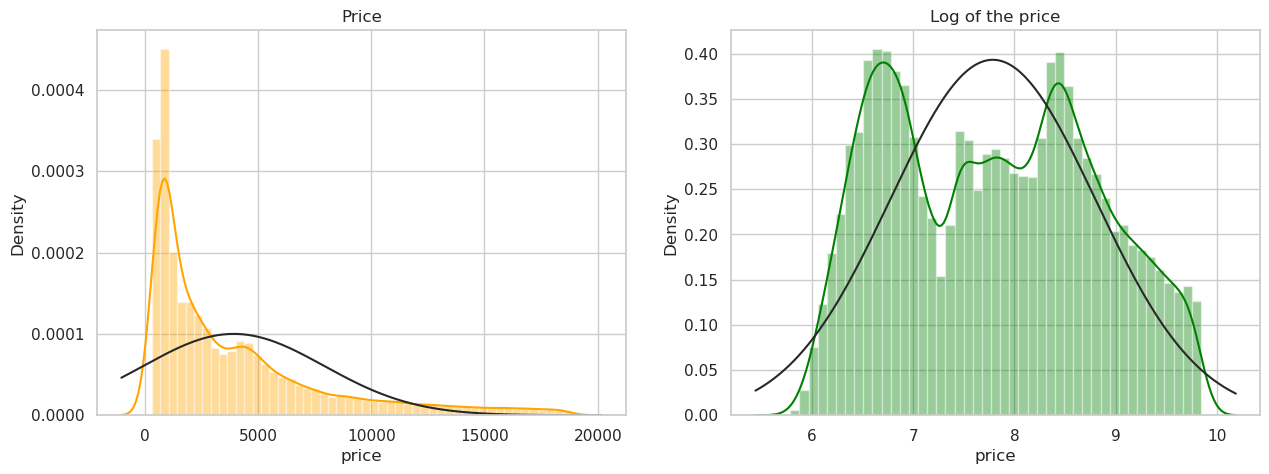

In [14]:
import math
## Comparing the price to a normal dist and
## Its log transformation to a normal dist.
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(df['price'], kde=True, fit=scipy.stats.norm , color='Orange')
plt.title('Price')
plt.subplot(1, 2, 2)
sns.distplot(np.log(df['price']), kde=True, fit=scipy.stats.norm, color='Green') ## fits is deprecated, this is good to demo.
plt.title(f'Log of the price')

In [15]:
## Adding the log of the price
diamantes.insert(2, 'log_price', [np.log(price) for price in diamantes["price"]])

In [16]:
# Drop rows with missing values
diamantes.dropna(inplace=True)

# Reset index
diamantes.reset_index(inplace=True, drop=True)

In [17]:
diamantes.head()

,color,price,log_price
0,E,326,5.786897
1,E,326,5.786897
2,E,327,5.789960
3,I,334,5.811141
4,I,336,5.817111


## One Way ANOVA:

One way a nova testing compares the means of one continuous 
dependent variable based on three or more groups of one categorical
variable.

To start lets look at a boxplot for the categorical variables vs log of the price

From the plot we can observe that the distributions by the selected colors overlap.
We can not make inferences between eachother, yet.

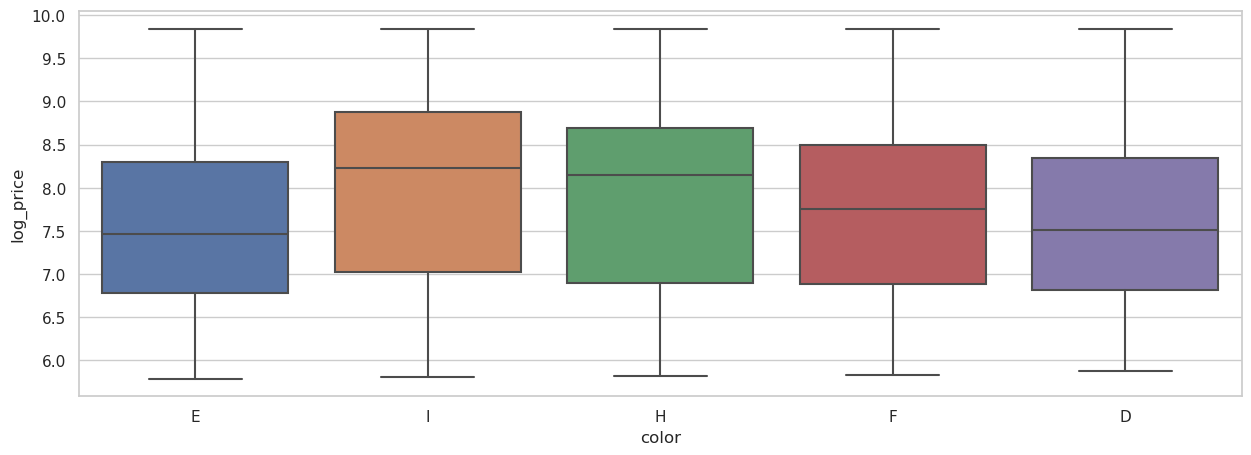

In [18]:
## box plot where we can observe 
plt.figure(figsize=(15, 5))
sns.boxplot(x='color', y='log_price', data=diamantes);

In [19]:
## after observing the relationship we can aastart as follow:

## Note:

The statsmodels.formula.api is very friendly and the offer of methods using R-style formulas.
Has vast content from regression, imputation, graphics, and generally ralated to statistics.

[API REFERENCE](https://www.statsmodels.org/devel/api.html#statsmodels-formula-api)


In [20]:
## 1. Construct a simple linear regression and fit the model:
## 2. Get a summary
mod1 = ols(formula = 'log_price ~ C(color)', data=diamantes).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     265.0
Date:                Wed, 21 Jun 2023   Prob (F-statistic):          3.81e-225
Time:                        21:38:26   Log-Likelihood:                -56185.
No. Observations:               39843   AIC:                         1.124e+05
Df Residuals:                   39838   BIC:                         1.124e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.6169      0.012    632.443      0.000       7.593       7.641
C(color)[T.E]    -0.0374      0.016     -2.390      0.017      -0.068      -0.007
C(color)[T.F]     0.1456      0.016      9.242      0.000       0.115       0.176
C(color)[T.H]     0.3015      0.016     18.580      0.000       0.270       0.333
C(color)[T.I]     0.4061      0.018     22.479      0.000       0.371       0.441
==============================================================================
Omnibus:                     7109.796   Durbin-Watson:                   0.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1542.621
Skew:                           0.079   Prob(JB):                         0.00
Kurtosis:                       2.049   Cond. No.                         6.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observations from mod1:

1. Based on the model summary table, the color grades' associated beta coefficients all have a p-value of less than 0.05. 
2. It is unclear if the price difference between the colors. This is when one-way ANOVA comes handy.
---
ANOVA:

**One way ANOVA test compares three or more groups of one categorical independent variable, based on one continuous dependent variable.**

Let's state the null and alternative hypotheses. 

#### *Null Hypothesis*

$H_0: price_D=price_E=price_F=price_H=price_I$

There is no difference in the price of diamonds based on color grade.

#### *Alternative Hypothesis*

$H_1: \text{Not } price_D=price_E=price_F=price_H=price_I$

There is a difference in the price of diamonds based on color grade.

---

**Note,** there are different ANOVA types 1, 2, and 3 which you can read about in the documentation. 

[**ANOVA-1-2-3**](https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.anova_lm.html)

---

The ANOVA table gives you:

* The sum of squares: and **degrees of freedom** for the color **variables and it's residuals**, as well as 
* The F statistic and p-value for the color variable. 

From the results:
the p-value is very small, 
which means that you can reject the null hypothesis,
that the mean of the price is the same for all diamond color grades. 


In [21]:
## OneWay ANOVA
sm.stats.anova_lm(mod1, type=2)

,df,sum_sq,mean_sq,F,PR(>F)
C(color),4.0,1041.508434,260.377108,264.95933,3.810297e-225
Residual,39838.0,39149.039438,0.982706,NaN,NaN


In [22]:
## type 1
sm.stats.anova_lm(mod1, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(color),4.0,1041.508434,260.377108,264.95933,3.810297e-225
Residual,39838.0,39149.039438,0.982706,NaN,NaN


In [23]:
## type 3 
sm.stats.anova_lm(mod1, type=3)


,df,sum_sq,mean_sq,F,PR(>F)
C(color),4.0,1041.508434,260.377108,264.95933,3.810297e-225
Residual,39838.0,39149.039438,0.982706,NaN,NaN


## Observations and conclusion from OneWayANOVA test:

Since the p-value (column PR(>F)) is very small, we can reject the null hypothesis that the mean of the price is the same for all diamond color grades

**Technical note:** The type of an ANOVA and the number of ways of an ANOVA are two distinct concepts: "type" (typ in statsmodels.stats.anova.anova_lm()) refers to how the sums of squares (these quantities are the building blocks for ANOVA) are calculated, while "K-way" means that there are K categorical factors in the analysis.

[type1, 2, 3](https://md.psych.bio.uni-goettingen.de/mv/unit/lm_cat/lm_cat_unbal_ss_explained.html)

## NOTE: 
When data is balanced, the factors are orthogonal, and types I, II and III all give the same results. 

Usually the hypothesis of interest is about the significance of one factor while controlling for the level of the other factors. This equates to using type II or III SS. In general, if there is no significant interaction effect, then type II is more powerful, and follows the principle of marginality. If interaction is present, then type II is 
inappropriate while type III can still be used, but results need to be interpreted with caution (in the presence of interactions, main effects are rarely interpretable).


---


## Two-way ANOVA 

In this part of the notebook, we will prepare a second dataset so we can perform a two-way ANOVA, which requires **two categorical varaibles**. We will start with the same diamonds dataset from the `seaborn` package.

Now, let's add another categorical variable into the mix, let's add in the **cut of the diamond**. There are three kinds of cuts to include ideal, premium, and very good. 

You can load in the dataset that has been cleaned, you'll do the same as before and first fit a regression model, but the equation will address the possible interaction effects between cut and color. The colon indicates interaction between the color and cut categorical variables. 

Before you run the two way ANOVA test, let's review the three hypothesis pairs you'll be testing. 

First up are 
 - The null and alternative hypotheses about diamond price based on color, next are 
 - The hypotheses about diamond price based on cut, lastly are 
 - The hypotheses about the interaction between color and cut on diamond price. 

The table includes a row for each of the two categorical variables, and a row for the interaction between cut and color. Since the p-value is very small for all three, you can reject all three null hypotheses. 

In conclusion, the logarithm of the price is not the same for different colors, additionally, the logarithm of the price is not the same for different diamond cuts. 

Finally, there is an interaction effect between the color and cut that impacts the price of the diamond. 

In [24]:
## Selecting the categorical feature color data for our experiment.
## Obtaining a subset for colorless diamonds

# Subset for color, cut, price columns
diamonds2 = df[["color","cut","price"]]

# Only include colorless diamonds
diamonds2 = diamonds2[diamonds2["color"].isin(["E","F","H","D","I"])]

# Only include ideal, premium, and very good diamonds
diamonds2 = diamonds2[diamonds2["cut"].isin(["Ideal","Premium","Very Good"])]

# Drop NaNs
diamonds2.dropna(inplace = True)

# Reset index
diamonds2.reset_index(inplace = True, drop = True)

# Add column for logarithm of price
diamonds2.insert(3,"log_price",[math.log(price) for price in diamonds2["price"]])

In [25]:
diamonds2.head()

,color,cut,price,log_price
0,E,Ideal,326,5.786897
1,E,Premium,326,5.786897
2,I,Premium,334,5.811141
3,I,Very Good,336,5.817111
4,H,Very Good,337,5.820083


## Two-way ANOVA test
Create a multiple linear regression model using the `ols()` function, 

fit the model to the data, and get the summary statistics.

**Note:** This regression model includes two categorical X variables: `color` and `cut`, and a variable to account for the interaction between `color` and `cut`. The interaction is denoted using the `:` symbol.

In [26]:
## 2wayANOVA

mod2 = ols(formula = "log_price ~ C(color) + C(cut) + C(color):C(cut)", data=diamonds2).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     119.5
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        21:38:26   Log-Likelihood:                -49162.
No. Observations:               34938   AIC:                         9.835e+04
Df Residuals:                   34923   BIC:                         9.848e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             7.4567      0.019    401.599      0.000       7.420       7.493
C(color)[T.E]                        -0.0056      0.024     -0.231      0.817      -0.053       0.042
C(color)[T.F]                         0.1755      0.024      7.166      0.000       0.128       0.224
C(color)[T.H]                         0.2756      0.026     10.739      0.000       0.225       0.326
C(color)[T.I]                         0.3787      0.028     13.294      0.000       0.323       0.435
C(cut)[T.Premium]                     0.2828      0.031      9.153      0.000       0.222       0.343
C(cut)[T.Very Good]                   0.2295      0.031      7.291      0.000       0.168       0.291
C(color)[T.E]:C(cut)[T.Premium]      -0.0321      0.040     -0.798      0.425      -0.111       0.047
C(color)[T.F]:C(cut)[T.Premium]       0.0313      0.040      0.775      0.438      -0.048       0.110
C(color)[T.H]:C(cut)[T.Premium]       0.0947      0.041      2.308      0.021       0.014       0.175
C(color)[T.I]:C(cut)[T.Premium]       0.0841      0.046      1.832      0.067      -0.006       0.174
C(color)[T.E]:C(cut)[T.Very Good]    -0.0930      0.041     -2.290      0.022      -0.173      -0.013
C(color)[T.F]:C(cut)[T.Very Good]    -0.1013      0.041     -2.459      0.014      -0.182      -0.021
C(color)[T.H]:C(cut)[T.Very Good]    -0.0247      0.043     -0.576      0.564      -0.109       0.059
C(color)[T.I]:C(cut)[T.Very Good]     0.0359      0.048      0.753      0.451      -0.057       0.129
==============================================================================
Omnibus:                     4859.835   Durbin-Watson:                   0.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1246.233
Skew:                           0.108   Prob(JB):                    2.42e-271
Kurtosis:                       2.100   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Observations

Based on the model summary table, many of the color grades' and cuts' associated beta coefficients have a p-value of less than 0.05 (check the `P>|t|` column). 

Some of the interactions also seem statistically signifcant. 

Two-way ANOVA examine further the relationships between price and the two categories of color grade and cut.

First, we have to state our **three pairs of null and alternative hypotheses:**

---
####  **Null Hypothesis (Color)** There is no difference in the price of diamonds based on color.

$$H_0: price_D=price_E=price_F=price_H=price_I$$

#### **Alternative Hypothesis (Color)** There is a difference in the price of diamonds based on color.

$$H_1: \text{Not } price_D=price_E=price_F=price_H=price_I$$

---

#### **Null Hypothesis (Cut)** There is no difference in the price of diamonds based on cut.

$$H_0: price_{Ideal}=price_{Premium}=price_{Very \space Good}$$

#### **Alternative Hypothesis (Cut)** There is a difference in the price of diamonds based on cut.

$$H_1: \text{Not } price_{Ideal}=price_{Premium}=price_{Very \space Good}$$

---

#### **Null Hypothesis (Interaction)**

$$H_0: \text{The effect of color on diamond price is independent of the cut, and vice versa.}$$

#### **Alternative Hypothesis (Interaction)**

$$H_1: \text{There is an interaction effect between color and cut on diamond price.}$$

---

In [27]:
## The syntax for a two-way ANOVA is the same as for a one-way ANOVA.

## Two way anova
sm.stats.anova_lm(mod2, type=2)

,df,sum_sq,mean_sq,F,PR(>F)
C(color),4.0,976.995702,244.248925,249.990135,3.976628e-212
C(cut),2.0,630.799411,315.399706,322.813354,1.213670e-139
C(color):C(cut),8.0,27.454447,3.431806,3.512472,4.572708e-04
Residual,34923.0,34120.967355,0.977034,NaN,NaN


In [28]:
sm.stats.anova_lm(mod2, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(color),4.0,976.995702,244.248925,249.990135,3.976628e-212
C(cut),2.0,630.799411,315.399706,322.813354,1.213670e-139
C(color):C(cut),8.0,27.454447,3.431806,3.512472,4.572708e-04
Residual,34923.0,34120.967355,0.977034,NaN,NaN


In [29]:
sm.stats.anova_lm(mod2, type=3)

,df,sum_sq,mean_sq,F,PR(>F)
C(color),4.0,976.995702,244.248925,249.990135,3.976628e-212
C(cut),2.0,630.799411,315.399706,322.813354,1.213670e-139
C(color):C(cut),8.0,27.454447,3.431806,3.512472,4.572708e-04
Residual,34923.0,34120.967355,0.977034,NaN,NaN


## Conclusion

Since all of the p-values (column `PR(>F)`) are very small, we can reject all three null hypotheses.
Therefore, there is evidence, at the 5% significance level, 
There is an interaction effect between color and cut on diamond price.

---

ANOVA Post Hoc Test

This part of the notebook contains all of the code that will be presented in the second part of this section in the course. The focus is on post hoc tests after one-way ANOVA using the `statsmodels` package in Python. 

Recall the following definitions:

* **One-way ANOVA:** Compares the means of one continuous dependent variable based on three or more groups of one categorical variable.
* **Post hoc test:** Performs a pairwise comparison between all available groups while controlling for the error rate.

**Note:** Recall that if we run multiple hypothesis tests all with a 95% confidence level, there is an increasing chance of a false positive, or falsely rejecting the null hypothesis. The post hoc test will control for this, and allows us to run many hypothesis tests while remaining confident with the accuracy of the results. Otherwise, be very careful when running multiple hypothesis tests.

Now that we have reconstructed the simple linear regression model, we can re-run the ANOVA.

In [30]:
## Run one-way ANOVA from the simple linear model from the first part of the notebook.
sm.stats.anova_lm(mod1, typ=2)

,sum_sq,df,F,PR(>F)
C(color),1041.508434,4.0,264.95933,3.810297e-225
Residual,39149.039438,39838.0,NaN,NaN


Since the p-value is very small and we can reject the null hypothesis

that the mean price is the same for all diamond color grades, we can continue on to run a post hoc test. 

The post hoc test is useful because the one-way ANOVA does not tell us which colors are associated with different prices. The post hoc test will give us more information.

### Post hoc test

There are many post hoc tests that can be run. One of the most common ANOVA post hoc tests is the Tukey's HSD (honestly significantly different) test. We can import the pairwise_tukeyhsd() function from the statsmodels package to run the test.

`from statsmodels.stats.multicomp import pairwise_tukeyhsd`

- The `endog` variable specifies which variable is being compared across groups, which is `log_price` in this case. 

- Then the `groups` variables indicates which variable holds the groups we're comparing, which is `color`. 

- `alpha` tells the function the significance or confidence level, which we'll set to `0.05`. 

- We'll aim for the typical 95% confidence level.

In [33]:
# Run Tukey's HSD post hoc test for one-way ANOVA
tukey_oneway = pairwise_tukeyhsd(
    endog = diamantes["log_price"], 
    groups = diamantes["color"], alpha = 0.05
)

In [35]:
## Displaying the results

## Each row represents a pariwise comparison between the prices 
## of two diamond color grades. The `reject` column tells us 
## which null hypotheses we can reject. Based on the values in 
## that column, we can reject each null hypothesis, except when 
## comparing D and E color diamonds. 
## We cannot reject the null hypothesis that the diamond price of D and E color diamonds are the same.

tukey_oneway.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
D,E,-0.0374,0.1181,-0.0802,0.0053,False
D,F,0.1456,0.0,0.1026,0.1885,True
D,H,0.3015,0.0,0.2573,0.3458,True
D,I,0.4061,0.0,0.3568,0.4553,True
E,F,0.183,0.0,0.1441,0.2219,True
E,H,0.339,0.0,0.2986,0.3793,True
E,I,0.4435,0.0,0.3977,0.4893,True
F,H,0.156,0.0,0.1154,0.1966,True
F,I,0.2605,0.0,0.2145,0.3065,True
H,I,0.1045,0.0,0.0573,0.1517,True


### Conclusions:

#### **Test 1: D vs. E**
$H_0: price_D=price_E$

The price of D and E color grade diamonds are the same.

$H_0: price_D \neq price_E$

The price of D and E color grade diamonds are not the same.

**Result:** We *cannot* reject the null hypothesis that the price of D and E color grade diamonds are the same.

---

#### **Test 2: D vs. F**
$H_0: price_D=price_F$

The price of D and F color grade diamonds are the same.

$H_0: price_D \neq price_F$

The price of D and F color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of D and F color grade diamonds are the same.

---

#### **Test 3: D vs. H**
$H_0: price_D=price_H$

The price of D and H color grade diamonds are the same.

$H_0: price_D \neq price_H$

The price of D and H color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of D and H color grade diamonds are the same.

---

#### **Test 4: D vs. I**
$H_0: price_D=price_I$

The price of D and I color grade diamonds are the same.

$H_0: price_D \neq price_I$

The price of D and I color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of D and I color grade diamonds are the same.

---

#### **Test 5: E vs. F**
$H_0: price_E=price_F$

The price of E and F color grade diamonds are the same.

$H_0: price_E \neq price_F$

The price of E and F color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of E and F color grade diamonds are the same.

---

#### **Test 6: E vs. H**
$H_0: price_E=price_H$

The price of E and H color grade diamonds are the same.

$H_0: price_E \neq price_H$

The price of E and H color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of E and H color grade diamonds are the same.

---

#### **Test 7: E vs. I**
$H_0: price_E=price_I$

The price of E and I color grade diamonds are the same.

$H_0: price_E \neq price_I$

The price of E and I color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of E and I color grade diamonds are the same.

---

#### **Test 8: F vs. H**
$H_0: price_F=price_H$

The price of F and H color grade diamonds are the same.

$H_0: price_F \neq price_H$

The price of F and H color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of F and H color grade diamonds are the same.

---

#### **Test 9: F vs. I**
$H_0: price_F=price_I$

The price of F and I color grade diamonds are the same.

$H_0: price_F \neq price_I$

The price of F and I color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of F and I color grade diamonds are the same.

---

#### **Test 10: H vs. I**
$H_0: price_H=price_I$

The price of H and I color grade diamonds are the same.

$H_0: price_H \neq price_I$

The price of H and I color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of H and I color grade diamonds are the same.

---